# Phase One: Data Collection & Cleaning (Pure Polars)
## Portfolio Management PPI Modeling Project

**Objective**: Collect and clean data for forecasting month-on-month percentage changes in PPI for portfolio management services (PPIDF01 Index).

**Key Data Sources**:
- Primary Target: PPIDF01 Index (PPI Portfolio Management, NSA) from FRED
- Market Returns: S&P 500, NASDAQ, Russell 2000, VIX
- Bond Markets: Treasury yields, corporate spreads
- Macro Indicators: Dollar index, commodities, employment data

**Technical Stack**: Pure Polars for all data manipulation, FRED API, caching system

In [6]:
import os
import polars as pl
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
from dotenv import load_dotenv
from pathlib import Path

# Load environment variables
load_dotenv()

# Import our data collection module
from data_collection import DataCollector

# Configure Polars
pl.Config.set_tbl_rows(10)
pl.Config.set_tbl_cols(8)

print(f"Pure Polars setup complete - Version: {pl.__version__}")

Pure Polars setup complete - Version: 1.31.0


In [7]:
# Check API key
fred_key = os.getenv('FRED_API_KEY')
if fred_key:
    print(f"FRED API key configured: {fred_key[:8]}...")
else:
    print("WARNING: FRED API key not found! Set FRED_API_KEY in .env file")

# Initialize collector
collector = DataCollector(cache_dir="data_cache")
print(f"Data collector initialized with cache: {collector.cache_dir}")

FRED API key configured: d90bf322...
Data collector initialized with cache: data_cache


In [8]:
# Collect all data
print("Starting data collection...")
all_data = collector.collect_all_data()

# Quick summary
target = all_data['target']
if target is not None:
    print(f"\nTarget data: {target.shape} - {target['date'].min()} to {target['date'].max()}")
    
    # Show basic stats
    stats = target.select([
        pl.col('value').count().alias('count'),
        pl.col('value').mean().alias('mean'),
        pl.col('value').std().alias('std'),
        pl.col('value').min().alias('min'),
        pl.col('value').max().alias('max')
    ])
    print("Target statistics:")
    print(stats)

Starting data collection...
starting comprehensive data collection for phase one...
fetching target variable: ppi for portfolio management services
fetching SP500 data...
fetching NASDAQCOM data...
fetching RUT data...
fetching VIXCLS data...
fetching DGS10 data...
fetching DGS2 data...
fetching DGS3MO data...
fetching BAMLC0A0CM data...
fetching DTWEXBGS data...
fetching DCOILWTICO data...
fetching GOLDAMGBD228NLBM data...
fetching UNRATE data...
fetching CPIAUCSL data...
data collection complete!

Target data: (229, 3) - 2003-12-01 to 2022-12-01
Target statistics:
shape: (1, 5)
┌───────┬────────────┬───────────┬───────┬─────────┐
│ count ┆ mean       ┆ std       ┆ min   ┆ max     │
│ ---   ┆ ---        ┆ ---       ┆ ---   ┆ ---     │
│ u32   ┆ f64        ┆ f64       ┆ f64   ┆ f64     │
╞═══════╪════════════╪═══════════╪═══════╪═════════╡
│ 229   ┆ 189.522349 ┆ 66.021738 ┆ 100.0 ┆ 337.374 │
└───────┴────────────┴───────────┴───────┴─────────┘


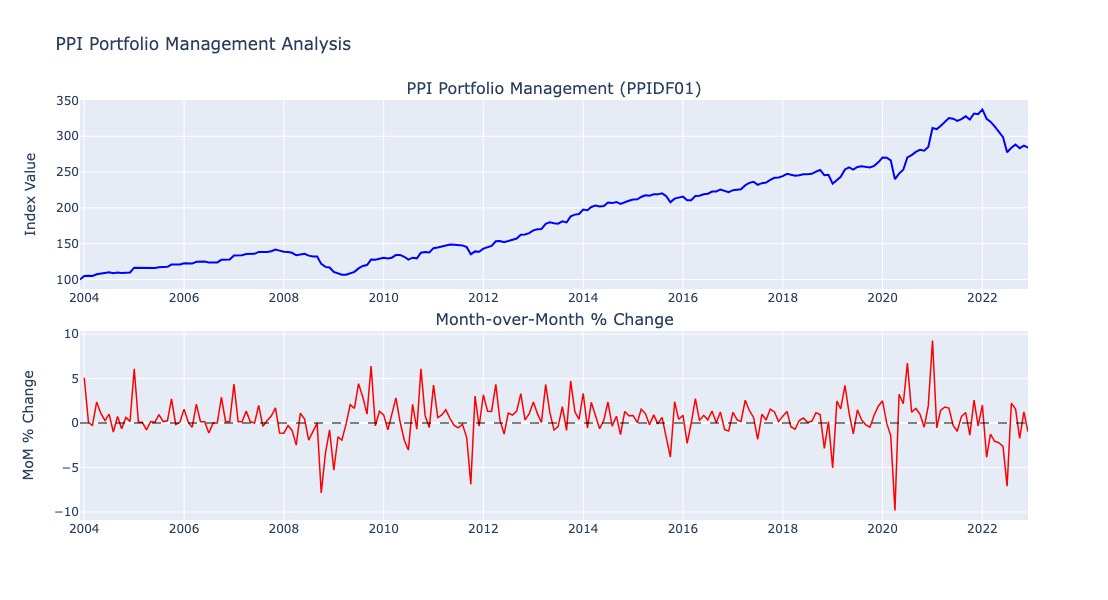


MoM % Change Statistics:
shape: (1, 4)
┌──────────┬─────────┬───────────┬──────────┐
│ mean_mom ┆ std_mom ┆ min_mom   ┆ max_mom  │
│ ---      ┆ ---     ┆ ---       ┆ ---      │
│ f64      ┆ f64     ┆ f64       ┆ f64      │
╞══════════╪═════════╪═══════════╪══════════╡
│ 0.482907 ┆ 2.18716 ┆ -9.838528 ┆ 9.294984 │
└──────────┴─────────┴───────────┴──────────┘


In [9]:
# Calculate MoM changes and visualize
if target is not None:
    target_enhanced = target.sort('date').with_columns([
        (pl.col('value').pct_change() * 100).alias('mom_pct')
    ])
    
    # Plot using plotly
    dates = target_enhanced['date'].to_list()
    values = target_enhanced['value'].to_list()
    mom_pct = target_enhanced['mom_pct'].to_list()
    
    # Create subplots
    fig = make_subplots(
        rows=2, cols=1,
        subplot_titles=('PPI Portfolio Management (PPIDF01)', 'Month-over-Month % Change'),
        vertical_spacing=0.1
    )
    
    # Add index value plot
    fig.add_trace(
        go.Scatter(
            x=dates, y=values,
            mode='lines',
            name='Index Value',
            line=dict(color='blue', width=2)
        ),
        row=1, col=1
    )
    
    # Add MoM % change plot
    fig.add_trace(
        go.Scatter(
            x=dates, y=mom_pct,
            mode='lines',
            name='MoM % Change',
            line=dict(color='red', width=1.5)
        ),
        row=2, col=1
    )
    
    # Add horizontal line at y=0 for MoM plot
    fig.add_hline(y=0, line_dash="dash", line_color="black", opacity=0.5, row=2, col=1)
    
    # Update layout
    fig.update_layout(
        height=600,
        title_text="PPI Portfolio Management Analysis",
        showlegend=False
    )
    
    # Update y-axis labels
    fig.update_yaxes(title_text="Index Value", row=1, col=1)
    fig.update_yaxes(title_text="MoM % Change", row=2, col=1)
    
    fig.show()
    
    # MoM statistics
    mom_stats = target_enhanced.select([
        pl.col('mom_pct').drop_nulls().mean().alias('mean_mom'),
        pl.col('mom_pct').drop_nulls().std().alias('std_mom'),
        pl.col('mom_pct').drop_nulls().min().alias('min_mom'),
        pl.col('mom_pct').drop_nulls().max().alias('max_mom')
    ])
    print("\nMoM % Change Statistics:")
    print(mom_stats)

In [5]:
# Save data in Parquet format for optimal Polars performance
parquet_dir = Path("data_cache/parquet")
parquet_dir.mkdir(parents=True, exist_ok=True)

# Save target
if target is not None:
    target.write_parquet(parquet_dir / "target_ppidf01.parquet")
    print("Target data saved as Parquet")

# Save other data
for category, data_dict in all_data.items():
    if category != 'target' and isinstance(data_dict, dict):
        for name, df in data_dict.items():
            if isinstance(df, pl.DataFrame):
                filename = f"{category}_{name.lower()}.parquet"
                df.write_parquet(parquet_dir / filename)
                print(f"{category} {name} saved")

print(f"\nAll data saved to {parquet_dir}")
print("Phase One Complete - Pure Polars Implementation")

Target data saved as Parquet
market_returns SP500 saved
market_returns NASDAQCOM saved
market_returns VIXCLS saved
bond_market DGS10 saved
bond_market DGS2 saved
bond_market DGS3MO saved
bond_market BAMLC0A0CM saved
macro_indicators DTWEXBGS saved
macro_indicators DCOILWTICO saved
macro_indicators UNRATE saved
macro_indicators CPIAUCSL saved

All data saved to data_cache/parquet
Phase One Complete - Pure Polars Implementation
